## Déchiffrement d'un code de subsitution 

Un code de substitution est simplement une permutation $\sigma$ de l'ensemble des symboles utilisés dans un texte, appelé alphabet et noté $\Sigma$.

On calcule une plausibilité pour une tentative de déchiffrement $f : \{ \text{espace de codage} \} \to \{ \text{alphabet usuel} \}$ définie par : 

$$Pl(f) = \frac{1}{N}\sum_{i=0}^{N-1}{\log \mathbb{P}(f(c_i),f(c_{i+1}))} $$ 

où le texte chiffré est la suite $c_0c_1\cdots c_N$ 

On cherche à maximiser cette plausibilité : on cherche à résoudre le problème d'optimisation suivant : 

Trouver $$ f^* = \text{Argmin}_f{Pl(f)} $$


References :
- https://www.youtube.com/watch?v=z4tkHuWZbRA&ab_channel=ScienceEtonnante
- Decrypting Classical Cipher Text Using Markov Chain Monte Carlo 
- The Markov Chain Monte Carlo Revolution

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
from itertools import pairwise
from random import shuffle

In [67]:
MIN_ITER = 2000
MAX_ITER = 10000
EPS = 1e-6
LANGUAGE = 'fr' # 'fr', en', 'esp', 'de', 'it' ...

In [68]:
SPACES = 1
if SPACES : 
    IOC = -3
else :
    IOC = -2.05

In [69]:
if SPACES :
    alphabet = [' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
else :
    alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [70]:
NB_SYMB = len(alphabet)

In [71]:
def char_to_int(c) :
    if SPACES :
        return 0 if c==" " else ord(c)-64
    else :
        return ord(c)-65

def int_to_char(i) :
    if SPACES :
        return " " if i==0 else chr(i+64)
    else : 
        return chr(i+65)

In [72]:
def normalise(text) :
    # Remove accent and punctuation
    # Put every letter in maj
    normalised_text = ""
    for s in text : 
        if (s in [",", ".", ";", "(", ")", "@"]) :
            normalised_text+=""
        elif s in ["'", "-", "’"]:
            normalised_text+=" "
        else :
            normalised_text+=s
    return unidecode(normalised_text).upper()

In [73]:
normalise("Non, rien de rien, non, je ne regrette rien")

'NON RIEN DE RIEN NON JE NE REGRETTE RIEN'

In [74]:
code = [i for i in range(NB_SYMB)]
shuffle(code)

In [75]:
print(code)

[4, 22, 6, 16, 11, 0, 7, 25, 2, 3, 15, 20, 17, 23, 19, 9, 13, 1, 5, 18, 24, 21, 14, 26, 12, 10, 8]


In [76]:
def cipher(plain_text, code) :
    cipher_text = ""
    t = normalise(plain_text)
    for c in t : 
        i=char_to_int(c)
        if 0<=i<=26 :
            cipher_text+=int_to_char(code[i])
        else :
            cipher_text+=c
    return cipher_text

In [77]:
cipher("NON, RIEN DE RIEN, NON, JE NE REGRETTE RIEN", code)

'SISDEC SDK DEC SDSISDO DS DE YE XX DEC S'

In [78]:
def multi_grams(filename, encod) :
    """ Return the frequencies and bigrams from a reference text"""
    
    mots = []
    
    file = open(filename, "r", encoding=encod)
    for l in file :
        mots.append(normalise(l))
    file.close()
    
    bigrams = np.zeros((NB_SYMB, NB_SYMB))
    freq = {}
    for i in alphabet :
        freq[i]=0

    for s in mots : 
        for c in s[:-1] :
            if 0<=char_to_int(c)<=26 :
                freq[c]+=1

        consecutive = list(pairwise(s))
        for a, b in consecutive :
            i, j = char_to_int(a), char_to_int(b)
            if 0<=i<=26 and 0<=j<=26 :
                bigrams[i, j]+=1

    for i in range(NB_SYMB):
        bigrams[i,:]/=np.sum(bigrams[i,:])

    
    return freq, bigrams # todo : add trigrams, quagrams ...

In [103]:
if LANGUAGE=='fr' :
    freq, bigrams = multi_grams("swann.txt", "utf-8")
    #freq, bigrams = multi_grams("liste.de.mots.francais.frgut.txt", "utf-8")
elif LANGUAGE=='en':
    freq, bigrams = multi_grams("War_and_Peace.txt", "latin1")

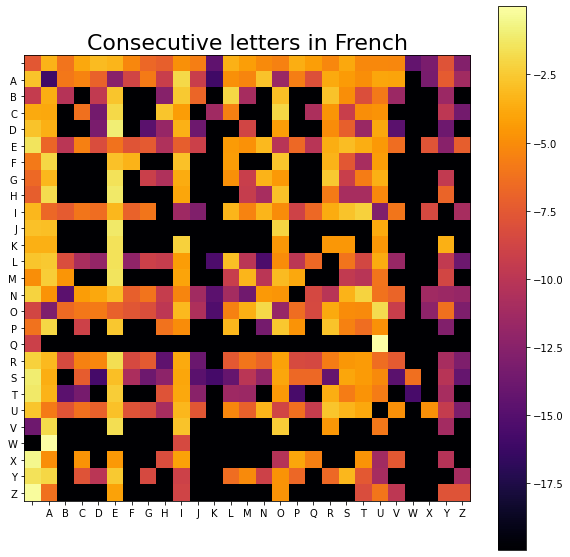

In [104]:
log_bigrams = np.log2(bigrams + EPS)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(log_bigrams, interpolation="nearest", cmap='inferno')
ax.xaxis.set_ticks(list(range(NB_SYMB)), labels = [int_to_char(i) for i in range(NB_SYMB)])
ax.yaxis.set_ticks(list(range(NB_SYMB)), labels = [int_to_char(i) for i in range(NB_SYMB)])
plt.title("Consecutive letters in {}".format("French" if LANGUAGE=='fr' else "English"), fontsize=22)
plt.colorbar()
plt.show()

[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
[0, 5, 1, 9, 19, 20, 14, 21, 18, 12, 15, 4, 13, 3, 16, 22, 17, 6, 2, 7, 8, 10, 24, 25, 26, 23, 11]
[' ', 'E', 'A', 'I', 'S', 'T', 'N', 'U', 'R', 'L', 'O', 'D', 'M', 'C', 'P', 'V', 'Q', 'F', 'B', 'G', 'H', 'J', 'X', 'Y', 'Z', 'W', 'K']
[' ', 'E', 'A', 'I', 'S', 'T', 'N', 'U', 'R', 'L', 'O', 'D', 'M', 'C', 'P', 'V', 'Q', 'F', 'B', 'G', 'H', 'J', 'X', 'Y', 'Z', 'W', 'K']


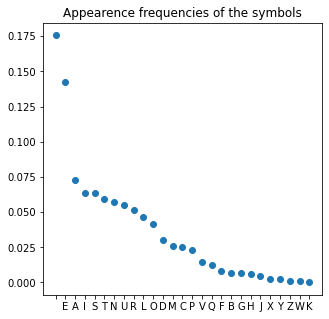

In [105]:
x = list(freq.keys())
print(x)
y = list(freq.values())
y = [i/sum(y) for i in y]
z = list(np.argsort(y))[::-1]
print(z)
y.sort()
y = y[::-1]
x = [x[i] for i in z]
print(x)
freq_fr = x
print(freq_fr)
fig, ax = plt.subplots(figsize=(5,5))
ax.xaxis.set_ticks(list(range(NB_SYMB)), labels = x)
plt.plot(y, 'o')
plt.title("Appearence frequencies of the symbols")
plt.show()

In [106]:
def invert(permutation) :
    n = len(permutation)
    inverse = [0 for _ in range(n)]
    for i in range(n) :
        inverse[i] = permutation.index(i)
        
    return inverse 

In [107]:
freq_fr = invert(list(z))

In [108]:
print(freq_fr)

[0, 2, 18, 13, 11, 1, 17, 19, 20, 3, 21, 26, 9, 12, 6, 10, 14, 16, 8, 4, 5, 7, 15, 25, 22, 23, 24]


In [109]:
# Extrait du début des Misérables de Victor Hugo

text = "En 1815, M. Charles-François-Bienvenu Myriel était évêque de Digne. C’était un vieillard d’environ soixante-quinze ans ; il occupait le siége de Digne depuis 1806. Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter, il n’est peut-être pas inutile, ne fût-ce que pour être exact en tout, d’indiquer ici les bruits et les propos qui avaient couru sur son compte au moment où il était arrivé dans le diocèse. Vrai ou faux, ce qu’on dit des hommes tient souvent autant de place dans leur vie et souvent dans leur destinée que ce qu’ils font. M. Myriel était fils d’un conseiller au parlement d’Aix ; noblesse de robe. On contait que son père, le réservant pour hériter de sa charge, l’avait marié de fort bonne heure, à dix-huit ou vingt ans, suivant un usage assez répandu dans les familles parlementaires. Charles Myriel, nonobstant ce mariage, avait, disait-on, beaucoup fait parler de lui. Il était bien fait de sa personne, quoique d’assez petite taille, élégant, gracieux, spirituel ; toute la première partie de sa vie avait été donnée au monde et aux galanteries. "
print(text.upper())

EN 1815, M. CHARLES-FRANÇOIS-BIENVENU MYRIEL ÉTAIT ÉVÊQUE DE DIGNE. C’ÉTAIT UN VIEILLARD D’ENVIRON SOIXANTE-QUINZE ANS ; IL OCCUPAIT LE SIÉGE DE DIGNE DEPUIS 1806. QUOIQUE CE DÉTAIL NE TOUCHE EN AUCUNE MANIÈRE AU FOND MÊME DE CE QUE NOUS AVONS À RACONTER, IL N’EST PEUT-ÊTRE PAS INUTILE, NE FÛT-CE QUE POUR ÊTRE EXACT EN TOUT, D’INDIQUER ICI LES BRUITS ET LES PROPOS QUI AVAIENT COURU SUR SON COMPTE AU MOMENT OÙ IL ÉTAIT ARRIVÉ DANS LE DIOCÈSE. VRAI OU FAUX, CE QU’ON DIT DES HOMMES TIENT SOUVENT AUTANT DE PLACE DANS LEUR VIE ET SOUVENT DANS LEUR DESTINÉE QUE CE QU’ILS FONT. M. MYRIEL ÉTAIT FILS D’UN CONSEILLER AU PARLEMENT D’AIX ; NOBLESSE DE ROBE. ON CONTAIT QUE SON PÈRE, LE RÉSERVANT POUR HÉRITER DE SA CHARGE, L’AVAIT MARIÉ DE FORT BONNE HEURE, À DIX-HUIT OU VINGT ANS, SUIVANT UN USAGE ASSEZ RÉPANDU DANS LES FAMILLES PARLEMENTAIRES. CHARLES MYRIEL, NONOBSTANT CE MARIAGE, AVAIT, DISAIT-ON, BEAUCOUP FAIT PARLER DE LUI. IL ÉTAIT BIEN FAIT DE SA PERSONNE, QUOIQUE D’ASSEZ PETITE TAILLE, ÉLÉG

In [110]:
def freq_ordre(text) :
    """Compute appearence frequencies of each symbol in a text"""
    freq = {}
    t = normalise(text)
    for l in alphabet :
        freq[l]=0
    for s in t : 
        if 0<=char_to_int(s)<=26 : 
            freq[s]+=1
            
    #print(freq)
    x = list(freq.keys())
    y = list(freq.values())
    #print(y)
    
    return invert(list(np.argsort(y))[::-1])

In [111]:
freq = freq_ordre(text)

In [112]:
print(freq)

[0, 2, 20, 12, 11, 1, 18, 17, 19, 3, 25, 24, 10, 14, 5, 9, 13, 16, 8, 7, 4, 6, 15, 26, 21, 22, 23]


In [113]:
print(list(map(int_to_char, invert(freq))))

[' ', 'E', 'A', 'I', 'T', 'N', 'U', 'S', 'R', 'O', 'L', 'D', 'C', 'P', 'M', 'V', 'Q', 'G', 'F', 'H', 'B', 'X', 'Y', 'Z', 'K', 'J', 'W']


In [114]:
def bigrams_score(text) :
    likelihood=0
    text_copy = normalise(text)
    c1 = text_copy[0]
    for c2 in text_copy[1:] :
        i, j = char_to_int(c1), char_to_int(c2)
        if 0<=i<=26 and 0<=j<=26 :
            likelihood+=log_bigrams[i, j]
        c1=c2
        
    return likelihood/len(text)

In [115]:
bigrams_score(text)

-3.0701013157171473

In [116]:
otis = """Mais, vous savez, moi je ne crois pas qu’il y ait de bonne ou de mauvaise situation. Moi, si je devais résumer ma vie aujourd’hui avec vous, je dirais que c’est d’abord des rencontres, des gens qui m’ont tendu la main, peut-être à un moment où je ne pouvais pas, où j’étais seul chez moi. Et c’est assez curieux de se dire que les hasards, les rencontres forgent une destinée... Parce que quand on a le goût de la chose, quand on a le goût de la chose bien faite, le beau geste, parfois on ne trouve pas l’interlocuteur en face, je dirais, le miroir qui vous aide à avancer"""
bigrams_score(otis)

-2.983330240839408

In [117]:
textc = cipher(text, code)
print(textc.upper())

 SD1815DWDPBVEQ RDGEVSPICRDFC SN SUDWJEC QD XVCXD N AU DK DKCYS DPD XVCXDUSDNC CQQVEKDKD SNCEISDRICLVSX DAUCSH DVSRDDCQDIPPUMVCXDQ DRC Y DK DKCYS DK MUCRD1806DAUICAU DP DK XVCQDS DXIUPB D SDVUPUS DWVSC E DVUDGISKDW W DK DP DAU DSIURDVNISRDVDEVPISX EDCQDSD RXDM UXD XE DMVRDCSUXCQ DS DGUXDP DAU DMIUED XE D LVPXD SDXIUXDKDCSKCAU EDCPCDQ RDFEUCXRD XDQ RDMEIMIRDAUCDVNVC SXDPIUEUDRUEDRISDPIWMX DVUDWIW SXDIUDCQD XVCXDVEECN DKVSRDQ DKCIP R DNEVCDIUDGVULDP DAUDISDKCXDK RDBIWW RDXC SXDRIUN SXDVUXVSXDK DMQVP DKVSRDQ UEDNC D XDRIUN SXDKVSRDQ UEDK RXCS  DAU DP DAUDCQRDGISXDWDWJEC QD XVCXDGCQRDKDUSDPISR CQQ EDVUDMVEQ W SXDKDVCLDDSIFQ RR DK DEIF DISDPISXVCXDAU DRISDM E DQ DE R ENVSXDMIUEDB ECX EDK DRVDPBVEY DQDVNVCXDWVEC DK DGIEXDFISS DB UE DVDKCLDBUCXDIUDNCSYXDVSRDRUCNVSXDUSDURVY DVRR HDE MVSKUDKVSRDQ RDGVWCQQ RDMVEQ W SXVCE RDPBVEQ RDWJEC QDSISIFRXVSXDP DWVECVY DVNVCXDKCRVCXDISDF VUPIUMDGVCXDMVEQ EDK DQUCDCQD XVCXDFC SDGVCXDK DRVDM ERISS DAUICAU DKDVRR HDM XCX DXVCQQ D Q YVSXDYEVPC ULDRMCECXU QDDXI

In [118]:
print(bigrams_score(textc))

-10.09856450323746


In [119]:
print(freq_fr)

[0, 2, 18, 13, 11, 1, 17, 19, 20, 3, 21, 26, 9, 12, 6, 10, 14, 16, 8, 4, 5, 7, 15, 25, 22, 23, 24]


In [120]:
## BREAKING A SUBSTITUTION CIPHER WITH A BIGRAM ATTACK

In [121]:
def decipher_deterministic(textc, N) :
    
    # TODO : renvoyer la clé de déchiffrement comme une permutation de NB_SYMB 
    
    # uni-gram attack as an initialization point  
    
    n = len(textc)
    t = normalise(textc)
    freq_textc = freq_ordre(t)
    decipher = ""
    for c in t :
        i = char_to_int(c)
        if 0<=i<=26 :
            freq_i = freq_textc[i]
            decipher+=int_to_char(freq_fr.index(freq_i))
        else : 
            decipher+=c
            
    decipher2=""
    
    #sequence of bi-gram attacks
    for k in range(N) :
        i, j = np.random.choice(alphabet, size=2, replace=False) # Tirage de 2 lettres de l'alphabet sans remise
        for c in decipher :
            if c==i :              
                decipher2+=j
            elif c==j :
                decipher2+=i
            else : 
                decipher2+=c
                
        if bigrams_score(decipher) < bigrams_score(decipher2) :
            decipher = decipher2
            
        decipher2 =""
        
    return decipher

In [122]:
t = decipher_deterministic(textc, 2500).upper()
print(t)

EN 1815 C MBARLES JRANMOIS FIENVENU CHRIEL ETAIT EVEQUE DE DIGNE M ETAIT UN VIEILLARD D ENVIRON SOIXANTE QUINZE ANS  IL OMMUPAIT LE SIEGE DE DIGNE DEPUIS 1806 QUOIQUE ME DETAIL NE TOUMBE EN AUMUNE CANIERE AU JOND CECE DE ME QUE NOUS AVONS A RAMONTER IL N EST PEUT ETRE PAS INUTILE NE JUT ME QUE POUR ETRE EXAMT EN TOUT D INDIQUER IMI LES FRUITS ET LES PROPOS QUI AVAIENT MOURU SUR SON MOCPTE AU COCENT OU IL ETAIT ARRIVE DANS LE DIOMESE VRAI OU JAUX ME QU ON DIT DES BOCCES TIENT SOUVENT AUTANT DE PLAME DANS LEUR VIE ET SOUVENT DANS LEUR DESTINEE QUE ME QU ILS JONT C CHRIEL ETAIT JILS D UN MONSEILLER AU PARLECENT D AIX  NOFLESSE DE ROFE ON MONTAIT QUE SON PERE LE RESERVANT POUR BERITER DE SA MBARGE L AVAIT CARIE DE JORT FONNE BEURE A DIX BUIT OU VINGT ANS SUIVANT UN USAGE ASSEZ REPANDU DANS LES JACILLES PARLECENTAIRES MBARLES CHRIEL NONOFSTANT ME CARIAGE AVAIT DISAIT ON FEAUMOUP JAIT PARLER DE LUI IL ETAIT FIEN JAIT DE SA PERSONNE QUOIQUE D ASSEZ PETITE TAILLE ELEGANT GRAMIEUX SPIRITUEL  TO

In [123]:
bigrams_score(t)

-3.235974201546468

In [124]:
def decipher_MCMC(textc) :
    # uni-gram attack as an initialization point 
    n = len(textc)
    t = normalise(textc)
    freq_textc = freq_ordre(t)
    decipher = ""
    for c in t :
        i = char_to_int(c)
        if 0<=i<=26 :
            freq_i = freq_textc[i]
            decipher+=int_to_char(freq_fr.index(freq_i))
        else : 
            decipher+=c
    
    best_decipher = decipher
    best_score = bigrams_score(decipher)
    decipher2=""
    count=0
    
    #sequence of bi-gram attacks
    for k in range(MAX_ITER) :
        count+=1
        i, j = np.random.choice(alphabet, size=2, replace=False) # Tirage de 2 lettres de l'alphabet sans remise
        for c in decipher :
            if c==i :              
                decipher2+=j
            elif c==j :
                decipher2+=i
            else : 
                decipher2+=c
                
        p = 2**((bigrams_score(decipher2)-bigrams_score(decipher))*n)
        
        u = np.random.rand(1)
        
        if u < p : 
            #print(l(decipher),l(decipher2))
            decipher=decipher2
            
            if bigrams_score(decipher)>best_score:
                best_decipher=decipher
                best_score=bigrams_score(decipher)

        
        decipher2 =""
        
        if (k>MIN_ITER) and (best_score>IOC) :
            print("count=", count)
            return best_decipher
        
    print("count=", count)
    return decipher

In [126]:
decipher_MCMC(cipher(text[:], code))

count= 10000


'EN 1815 M CHARLES JRANCOIS FIENVENU MBRIEL ETAIT EVEQUE DE DIGNE C ETAIT UN VIEILLARD D ENVIRON SOIXANTE QUINZE ANS  IL OCCUPAIT LE SIEGE DE DIGNE DEPUIS 1806 QUOIQUE CE DETAIL NE TOUCHE EN AUCUNE MANIERE AU JOND MEME DE CE QUE NOUS AVONS A RACONTER IL N EST PEUT ETRE PAS INUTILE NE JUT CE QUE POUR ETRE EXACT EN TOUT D INDIQUER ICI LES FRUITS ET LES PROPOS QUI AVAIENT COURU SUR SON COMPTE AU MOMENT OU IL ETAIT ARRIVE DANS LE DIOCESE VRAI OU JAUX CE QU ON DIT DES HOMMES TIENT SOUVENT AUTANT DE PLACE DANS LEUR VIE ET SOUVENT DANS LEUR DESTINEE QUE CE QU ILS JONT M MBRIEL ETAIT JILS D UN CONSEILLER AU PARLEMENT D AIX  NOFLESSE DE ROFE ON CONTAIT QUE SON PERE LE RESERVANT POUR HERITER DE SA CHARGE L AVAIT MARIE DE JORT FONNE HEURE A DIX HUIT OU VINGT ANS SUIVANT UN USAGE ASSEZ REPANDU DANS LES JAMILLES PARLEMENTAIRES CHARLES MBRIEL NONOFSTANT CE MARIAGE AVAIT DISAIT ON FEAUCOUP JAIT PARLER DE LUI IL ETAIT FIEN JAIT DE SA PERSONNE QUOIQUE D ASSEZ PETITE TAILLE ELEGANT GRACIEUX SPIRITUEL  T

In [127]:
decipher_MCMC(cipher(text[:300], code))

count= 10000


'EN 1815 M CHALSET PLANCOIT FIENVENU MBLIES ERAIR EVEQUE DE DIGNE C ERAIR UN VIEISSALD D ENVILON TOIXANRE QUINYE ANT  IS OCCUJAIR SE TIEGE DE DIGNE DEJUIT 1806 QUOIQUE CE DERAIS NE ROUCHE EN AUCUNE MANIELE AU POND MEME DE CE QUE NOUT AVONT A LACONREL IS N ETR JEUR ERLE JAT INURISE NE PUR CE QU'

In [128]:
decipher_MCMC(cipher(text[:250], code))

count= 10000


'EI 1815 C MPAYSET GYAIMOUT QUEINEIL CHYUES ERAUR ENEBLE DE DUVIE M ERAUR LI NUEUSSAYD D EINUYOI TOUJAIRE BLUIXE AIT  US OMMLFAUR SE TUEVE DE DUVIE DEFLUT 1806 BLOUBLE ME DERAUS IE ROLMPE EI ALMLIE CAIUEYE AL GOID CECE DE ME BLE IOLT ANOIT A YAMO'

In [78]:
turing="""L’article « Computing Machinery and Intelligence » qu’Alan Turing publie en 1950 est un incontournable pour tout chercheur en informatique ou toute personne intéressée par l’intelligence artificielle. Facilement accessible sur Internet (le site <scholar.google.fr> donne accès à 218 versions1) ou même en fac-similé sur le site TuringArchive.org 2 , cet article présente une discussion sur ce qui, selon l’auteur, dotera les machines de capa- cités intelligentes et de ce qui permettra d’en convaincre tout un chacun"""

In [79]:
turing.upper()

'L’ARTICLE « COMPUTING MACHINERY AND INTELLIGENCE » QU’ALAN TURING PUBLIE EN 1950 EST UN INCONTOURNABLE POUR TOUT CHERCHEUR EN INFORMATIQUE OU TOUTE PERSONNE INTÉRESSÉE PAR L’INTELLIGENCE ARTIFICIELLE. FACILEMENT ACCESSIBLE SUR INTERNET (LE SITE <SCHOLAR.GOOGLE.FR> DONNE ACCÈS À 218 VERSIONS1) OU MÊME EN FAC-SIMILÉ SUR LE SITE TURINGARCHIVE.ORG 2 , CET ARTICLE PRÉSENTE UNE DISCUSSION SUR CE QUI, SELON L’AUTEUR, DOTERA LES MACHINES DE CAPA- CITÉS INTELLIGENTES ET DE CE QUI PERMETTRA D’EN CONVAINCRE TOUT UN CHACUN'

In [80]:
cipher(turing, code)

' LVIZKU NL<<LUYCOSZKHFLCVUGKHNITLVHPLKHZN  KFNHUNL>>LJSLV VHLZSIKHFLOSB KNLNHL1950LNAZLSHLKHUYHZYSIHVB NLOYSILZYSZLUGNIUGNSILNHLKHEYICVZKJSNLYSLZYSZNLONIAYHHNLKHZNINAANNLOVIL LKHZN  KFNHUNLVIZKEKUKN  NLEVUK NCNHZLVUUNAAKB NLASILKHZNIHNZL NLAKZNL<AUGY VIFYYF NEI>LPYHHNLVUUNALVL218LMNIAKYHA1LYSLCNCNLNHLEVULAKCK NLASIL NLAKZNLZSIKHFVIUGKMNYIFL2LLUNZLVIZKU NLOINANHZNLSHNLPKAUSAAKYHLASILUNLJSKLAN YHL LVSZNSILPYZNIVL NALCVUGKHNALPNLUVOVLLUKZNALKHZN  KFNHZNALNZLPNLUNLJSKLONICNZZIVLPLNHLUYHMVKHUINLZYSZLSHLUGVUSH'

In [81]:
decipher_MCMC(cipher(turing, code))

count= 10000


'M ARTISME << SOVBUTIND VASPINERZ ANC INTEMMIDENSE >> QU AMAN TURIND BUGMIE EN 1950 ELT UN INSONTOURNAGME BOUR TOUT SPERSPEUR EN INFORVATIQUE OU TOUTE BERLONNE INTERELLEE BAR M INTEMMIDENSE ARTIFISIEMME FASIMEVENT ASSELLIGME LUR INTERNET ME LITE <LSPOMARDOODMEFR> CONNE ASSEL A 218 JERLIONL1 OU VEVE EN FAS LIVIME LUR ME LITE TURINDARSPIJEORD 2  SET ARTISME BRELENTE UNE CILSULLION LUR SE QUI LEMON M AUTEUR COTERA MEL VASPINEL CE SABA  SITEL INTEMMIDENTEL ET CE SE QUI BERVETTRA C EN SONJAINSRE TOUT UN SPASUN'

In [82]:
otis = """Mais, vous savez, moi je ne crois pas qu’il y ait de bonne ou de mauvaise situation. Moi, si je devais résumer ma vie aujourd’hui avec vous, je dirais que c’est d’abord des rencontres, des gens qui m’ont tendu la main"""#, peut-être à un moment où je ne pouvais pas, où j’étais seul chez moi. Et c’est assez curieux de se dire que les hasards, les rencontres forgent une destinée… Parce que quand on a le goût de la chose, quand on a le goût de la chose bien faite, le beau geste, parfois on ne trouve pas l’interlocuteur en face, je dirais, le miroir qui vous aide à avancer"""

In [83]:
otis.upper()

'MAIS, VOUS SAVEZ, MOI JE NE CROIS PAS QU’IL Y AIT DE BONNE OU DE MAUVAISE SITUATION. MOI, SI JE DEVAIS RÉSUMER MA VIE AUJOURD’HUI AVEC VOUS, JE DIRAIS QUE C’EST D’ABORD DES RENCONTRES, DES GENS QUI M’ONT TENDU LA MAIN'

In [84]:
cipher(otis, code)

'CVKALMYSALAVMNWLCYKLDNLHNLUIYKALOVALJSLK LTLVKZLPNLBYHHNLYSLPNLCVSMVKANLAKZSVZKYHLCYKLAKLDNLPNMVKALINASCNILCVLMKNLVSDYSIPLGSKLVMNULMYSALDNLPKIVKALJSNLULNAZLPLVBYIPLPNALINHUYHZINALPNALFNHALJSKLCLYHZLZNHPSL VLCVKH'

In [85]:
len(otis)

217

In [87]:
hamlet = """To be, or not to be: that is the question: Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune, Or to take arms against a sea of troubles, And by opposing end them"""

In [88]:
if LANGUAGE=='en' :
    cipher(hamlet, code)
    print(decipher_MCMC(cipher(hamlet, code)))    

In [89]:
print(freq_ordre(hamlet))

[0, 6, 11, 24, 13, 3, 12, 14, 9, 8, 22, 19, 16, 15, 5, 2, 17, 21, 7, 4, 1, 10, 23, 18, 25, 20, 26]


In [90]:
print(list(map(int_to_char, invert(freq_ordre(hamlet)))))

[' ', 'T', 'O', 'E', 'S', 'N', 'A', 'R', 'I', 'H', 'U', 'B', 'F', 'D', 'G', 'M', 'L', 'P', 'W', 'K', 'Y', 'Q', 'J', 'V', 'C', 'X', 'Z']


In [94]:
## TODO : BREAKING TRANSPOSITION CIPHER